## Effectiveness of AutoMS

### Import package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from AutoMS import hpic
from AutoMS import peakeval

### Plot distribution

In [2]:
file = 'data/600mix_pos.mzML'
peaks, pics = hpic.hpic(file, min_intensity=500, min_snr=1, mass_inv=1, rt_inv=30)

D:\AutoMS\AutoMS\mspd.py:100: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  col = int(mode(ridge[1, inds])[0][0])


C:\Users\DELL\AppData\Local\Temp\ipykernel_17236\2759890454.py:6: RuntimeWarning: invalid value encountered in divide
  X[i,:] = X[i,:] / np.max(X[i,:])


1361/1361 [==============================] - 4s 1ms/step


  0%|                                                                                        | 0/25257 [00:00<?, ?it/s]D:\AutoMS\AutoMS\mspd_original.py:125: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  col = int(mode(ridge[1, inds])[0][0])
100%|███████████████████████████████████████████████████████████████████████████| 25257/25257 [01:52<00:00, 224.88it/s]


790/790 [==============================] - 1s 1ms/step


C:\Users\DELL\anaconda3\envs\automs\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\DELL\anaconda3\envs\automs\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


625/625 [==============================] - 1s 1ms/step


C:\Users\DELL\anaconda3\envs\automs\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\DELL\anaconda3\envs\automs\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\DELL\anaconda3\envs\automs\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

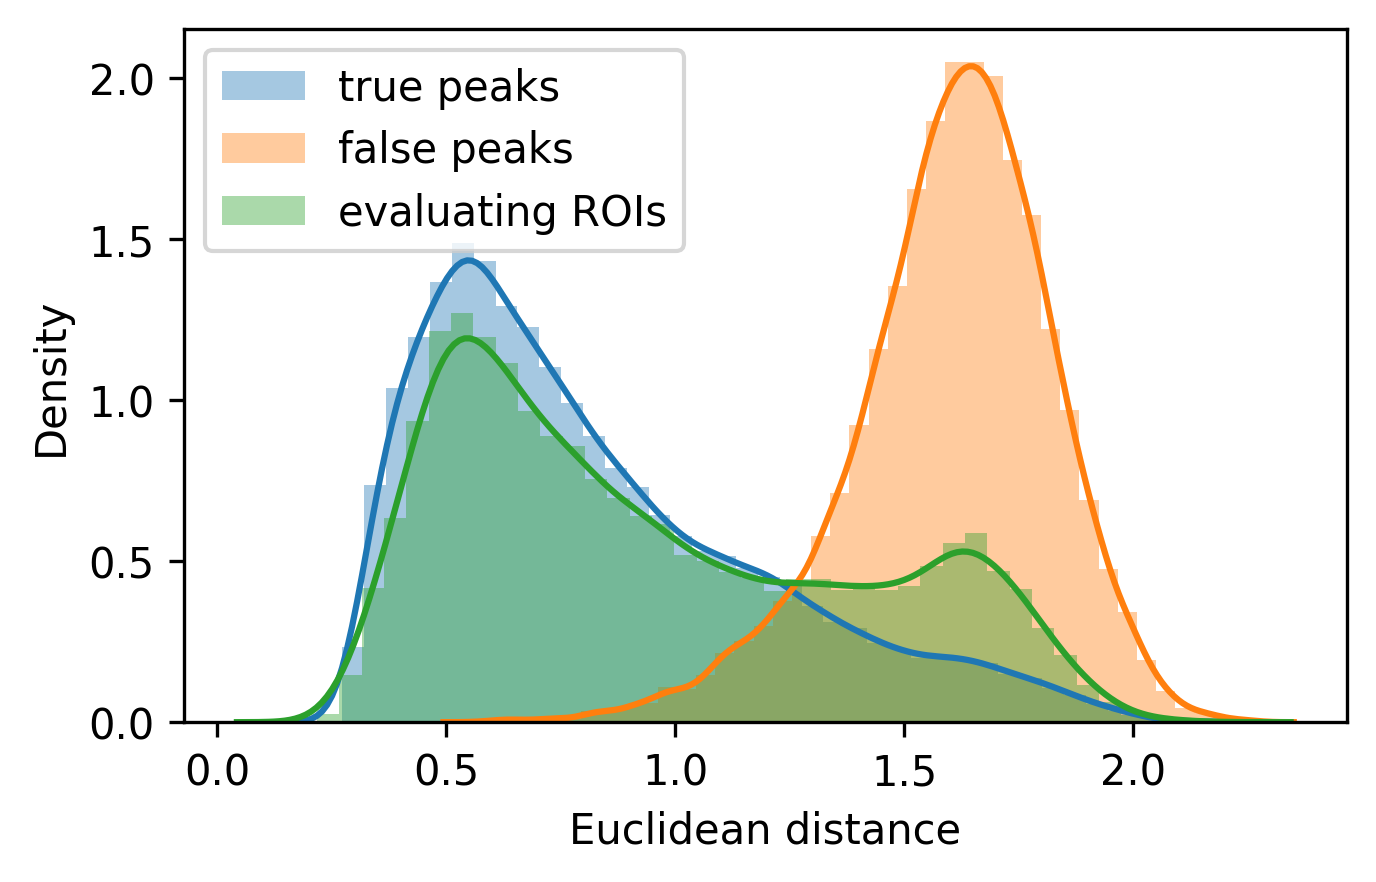

In [3]:
X = np.load('data/X.npy')
y = np.load('data/Y.npy')

keep = []
for i in range(X.shape[0]):
    X[i,:] = X[i,:] / np.max(X[i,:])
    v = X[i,:]
    if y[i] == 1:
        if np.sum(v[23:28] > 0) == 5:
            if max(v[24], v[25]) >= np.max(v[23:28]):
                keep.append(i)
                
X_true = X[keep, :]

autoencoder = tf.keras.models.load_model('model/denoising_autoencoder.pkl')
X_rebuild = autoencoder.predict(X_true)
X_rebuild = np.reshape(X_rebuild, [-1, 50])
dist_true = np.array([np.linalg.norm(X_true[i] - X_rebuild[i]) for i in range(len(X_true))])
scores, _, X, X_rebuild, dist_eval = peakeval.evaluate_peaks(peaks, pics, cal_snr=True)
dist_false, _, _ = peakeval.evaluate_noise()

plt.figure(dpi = 300, figsize = (5,3))
sns.distplot(dist_true, kde=True, bins = 40, label = 'true peaks')
sns.distplot(dist_false, kde=True, bins = 40, label = 'false peaks')
sns.distplot(dist_eval, kde=True, bins = 40, label = 'evaluating ROIs')
plt.xlabel('Euclidean distance', fontsize = 10)
plt.legend()

### Example plot

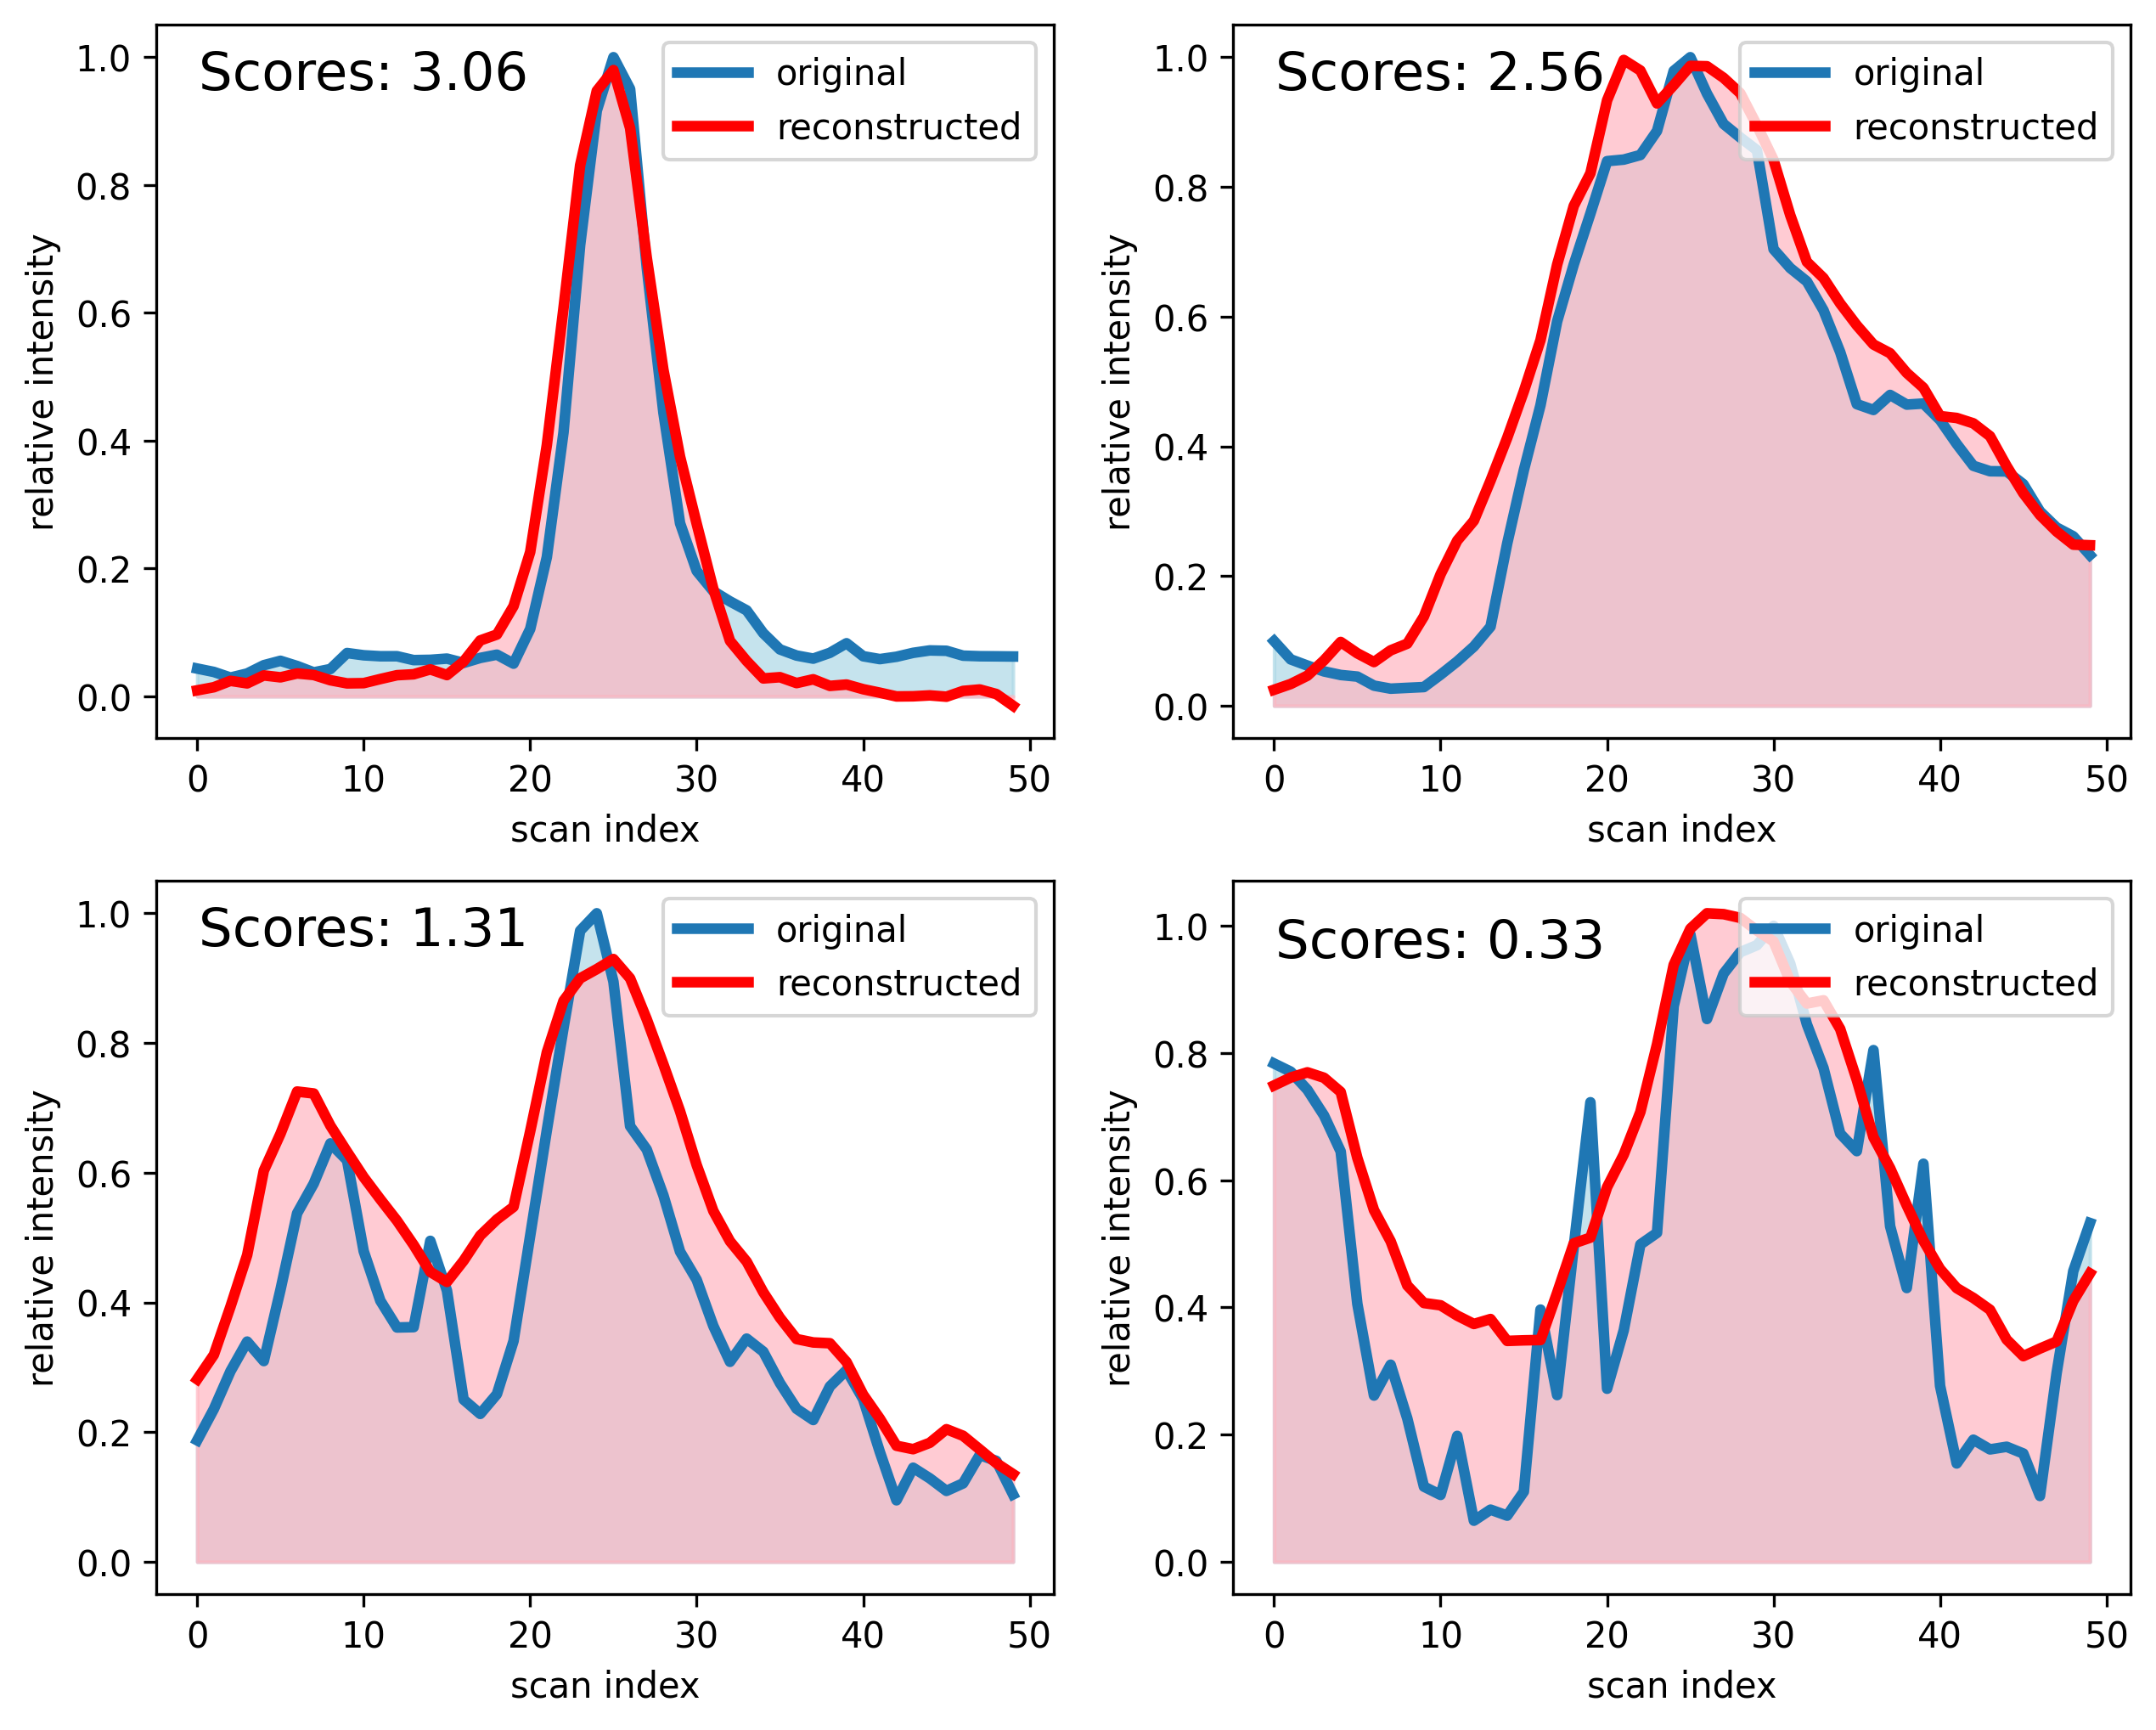

In [4]:
plt.figure(dpi = 300, figsize = (10,8))
for i, k in enumerate([2800, 2794, 6069, 6756]):
    y = X[k,:]
    y2 = X_rebuild[k,:]
        
    plt.subplot(2, 2, i+1)
    plt.plot(y, lw = 3, label = 'original')
    plt.fill_between(np.arange(50), y, color = 'lightblue', alpha = 0.7)
    
    plt.plot(y2, lw = 3, color = 'red', label = 'reconstructed')
    plt.fill_between(np.arange(50), y2, color = 'lightpink', alpha = 0.7)
    plt.text(0.1, 0.95, 'Scores: {}'.format(round(scores[k], 2)), fontsize = 15)
    
    plt.legend(loc = 'upper right')
    plt.xlabel('scan index')
    plt.ylabel('relative intensity')

### Test various profiles

1/1 [==============================] - 0s 81ms/step


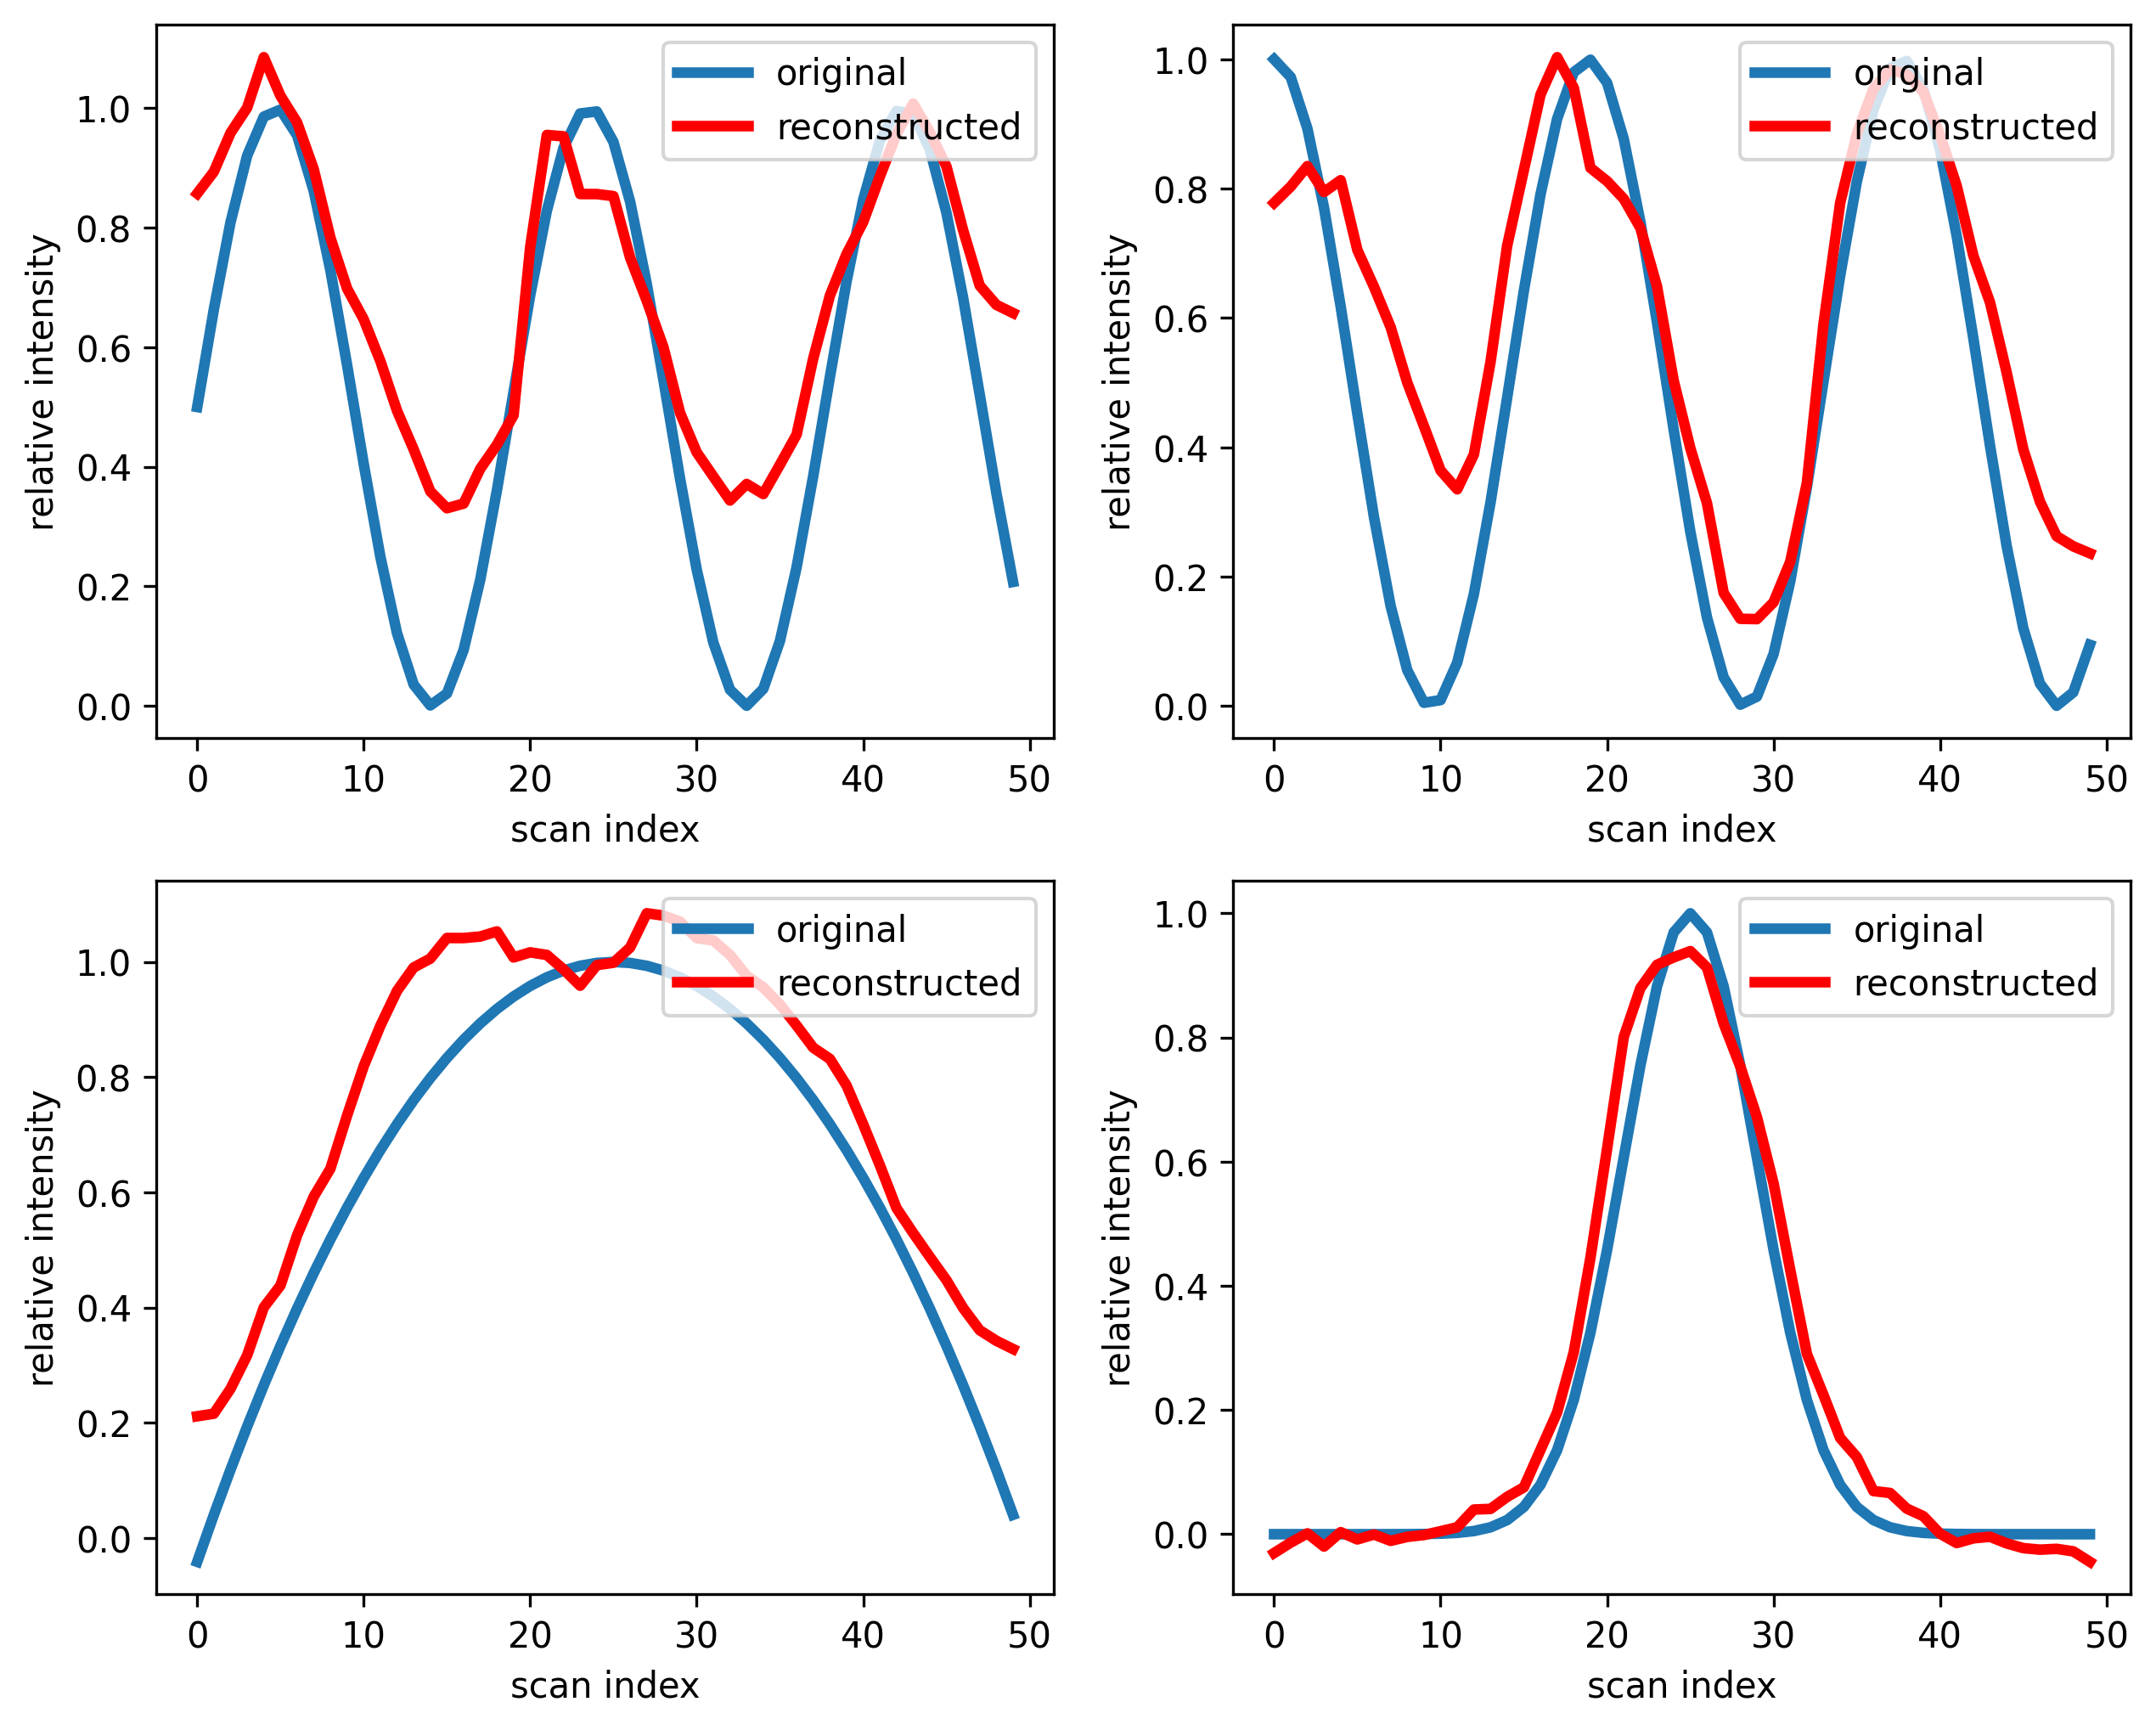

In [5]:
x = np.arange(50)
x1 = (np.sin(x / 3) + 1) / 2 # sine curve
x2 = (np.cos(x / 3) + 1) / 2 # cosine curve
x3 = (-(x-25)**2 + 600) / 600 # parabola curve
x4 = np.exp(-np.power(x - 25, 2.) / (2 * np.power(4, 2.))) # gaussian curve

X_curve = np.vstack((x1, x2, x3, x4))
X_curve_rebuild = autoencoder.predict(X_curve)
X_curve_rebuild = np.reshape(X_curve_rebuild, [-1, 50])


plt.figure(dpi = 300, figsize = (10,8))
for i in range(4):
    y = X_curve[i,:]
    y2 = X_curve_rebuild[i,:]
        
    plt.subplot(2, 2, i+1)
    plt.plot(y, lw = 3, label = 'original')  
    plt.plot(y2, lw = 3, color = 'red', label = 'reconstructed')
  
    plt.legend(loc = 'upper right')
    plt.xlabel('scan index')
    plt.ylabel('relative intensity')